* 이동평균선(이평선)
    - 주식시장이나 파생상품시장에서 기술적 분석을 할 때 쓰이는 기본 도구
    - 거래액, 매매대금, 주가 등 다양한 분야에서 접목
    - 과거의 평균적 수치에서 현상을 파악(주로 추세)
    - 현재의 매매와 미래의 예측에 접목할 수 돕는 것이 목적
* 종류
    - 단순이평(SMA)
    - 지수평균(EMA)
    - 가중평균(WMA)


In [29]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# 데이터 베이스 사용하기 SQLITE3
def seldata(dstart='2021-07-01',dend='2021-12-20'):
    dbname='../_db/stockdb.db'
    with sqlite3.connect(dbname) as conn:
        cur=conn.cursor()
        cols='sday,sopenp,shighp,slowp,sclosep,svol'
        selsql="select "+cols+" from stockp where sday>='"+dstart+"' and sday<='"+dend+"' order by sday asc"
        sdata=cur.execute(selsql).fetchall()
    return sdata

In [31]:
sdata=seldata()
cols=['sday','sopenp','shighp','slowp','sclosep','svol']
sdf=pd.DataFrame(sdata,columns=cols)
tdf=sdf.set_index('sday')
tdf.head()

,sopenp,shighp,slowp,sclosep,svol
sday,,,,,
2021-07-01,31250,31800,32150,31200,1641174
2021-07-02,31350,31300,31600,31300,1022673
2021-07-05,31850,31600,32250,31250,2594913
2021-07-06,32250,32050,32650,32000,1955885
2021-07-07,31500,31800,31800,31300,1885914


<AxesSubplot:xlabel='sday'>

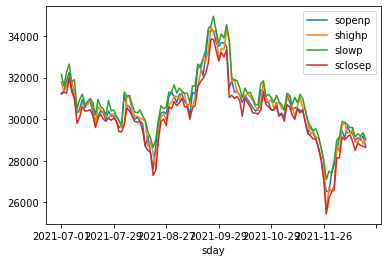

In [32]:
tdf[['sopenp','shighp','slowp','sclosep']].plot()

In [33]:
### 단이평선 5
tdf['shortmv']=tdf['sclosep'].rolling(window=5).mean()
### 장이평선 5
tdf['longmv']=tdf['sclosep'].rolling(window=20).mean()
wdf=tdf.fillna(0)

In [34]:
wdf.head()

,sopenp,shighp,slowp,sclosep,svol,shortmv,longmv
sday,,,,,,,
2021-07-01,31250,31800,32150,31200,1641174,0.0,0.0
2021-07-02,31350,31300,31600,31300,1022673,0.0,0.0
2021-07-05,31850,31600,32250,31250,2594913,0.0,0.0
2021-07-06,32250,32050,32650,32000,1955885,0.0,0.0
2021-07-07,31500,31800,31800,31300,1885914,31410.0,0.0


(25000.0, 34000.0)

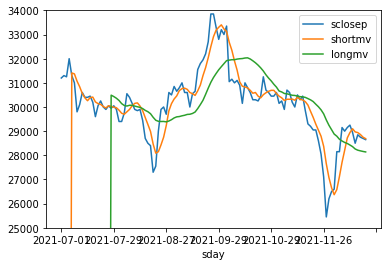

In [35]:
wdf[['sclosep','shortmv','longmv']].plot()
plt.ylim(25000,34000)

### 투자방법 
* 가치투자(기업의 가치)
    - 재무재표
    - 현금 흐름표
    - 기업의 가치를 알기위해서 오랜 시간이 필요
    - 빠른 세상의 변화에 대응 어려움
* 기술투자(모멘텀)
    - 오픈시장하에서 가격이 곧 정보의 종합판
    - 가격에 모든 정보가 녹아있다
    - 가격의 모멘텀(흐름) 
    - 빠른 세상의 변화에 대응
    
### 장단기 이평선을 통한 매수 매매 타이밍
* 분석
    - 단이평선 > 장이평선: 장기적으로 상승세에 있다
    - 단이평선 < 장이평선: 장기적으로 하락세에 있다
* 크로스
    - 골든크로스
        * 단이평선이 장이평선 아래에서 위로 뚫고 올라갔을때
        * 하락세->상승세
        * 매수세가 강하다
        * 살 타이밍
    - 데드크로스
        * 단이평선이 장이평선 위에서 아래로 뚫고 내려갔을때
        * 상승세->하락세
        * 매도세가 강하다
        * 팔 타이밍
    
    

In [45]:
# 2개월간 5일 단이평선 20일 장이평선 기준의 매수매매 전략
beforepos=-1 # 이평선 포지션
beforehold=0 # 주식 보유여부
for i,row in wdf.iloc[:,:].iterrows():
    #print(i,'\n',row)
    if row['shortmv']>row['longmv']:
        nowpos=1 ## 매수 포지션
    else:
        nowpos=-1
    if(row['longmv']==0):
        nowpos=-1
    wdf.loc[i,'nowpos']=nowpos # 현재 포지션
    
    if nowpos>beforepos and beforehold==0: # 매수신호
        timing=1
        hold=1
        wdf.loc[i,'cash']=-row['sclosep']
    elif nowpos<beforepos and beforehold==1:
        timing=-1
        hold=0
        wdf.loc[i,'cash']=row['sclosep']
    else:
        timing=0
        hold=beforehold
        
    wdf.loc[i,'hold']=hold # 주식 보유 여부
    wdf.loc[i,'timing']=timing
    beforepos=nowpos
    beforehold=hold
wdf['cash'][0]=32000
wdf['cumcash']=wdf['cash'].cumsum()
wdf['balance']=wdf['sclosep']*wdf['hold']+wdf['cumcash']
scols=['sclosep','longmv','nowpos','timing','hold','cash','cumcash','balance']
print('시작가:',wdf['sclosep'][0],
      ' 종가:',wdf['sclosep'][-1],
      '차이:',wdf['sclosep'][-1]-wdf['sclosep'][0],
      '잔고:',wdf['balance'][-1],
      '수익:',wdf['balance'][-1]-wdf['balance'][0],
     )
wdf[scols].head(30)


시작가: 31200  종가: 28650 차이: -2550 잔고: 31450.0 수익: -550.0


<ipython-input-45-670524950c1d>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wdf['cash'][0]=32000


,sclosep,longmv,nowpos,timing,hold,cash,cumcash,balance
sday,,,,,,,,
2021-07-01,31200,0.0,-1.0,0.0,0.0,32000.0,32000.0,32000.0
2021-07-02,31300,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-05,31250,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-06,32000,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-07,31300,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-08,31000,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-09,29800,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-12,30100,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-13,30600,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0


(30.0, 90.0)

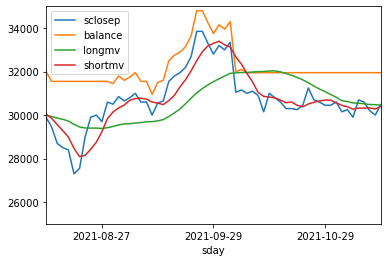

In [43]:
wdf[['sclosep','balance','longmv','shortmv']].plot()
plt.ylim(25000,35000)
plt.xlim(30,90)